In [1]:
# Import Necessary Libraries  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [2]:
# Load and Explore Data  
# Load the datasets
books_df = pd.read_csv(r"C:\Users\Sosa the chief\Desktop\python\portfolio\book recommender\Books.csv", low_memory=False)
ratings_df = pd.read_csv(r"C:\Users\Sosa the chief\Desktop\python\portfolio\book recommender\Ratings.csv")
users_df = pd.read_csv(r"C:\Users\Sosa the chief\Desktop\python\portfolio\book recommender\Users.csv")

# Display the first few rows of each dataset
print("Books DataFrame:")
print(books_df.head())

print("\nRatings DataFrame:")
print(ratings_df.head())

print("\nUsers DataFrame:")
print(users_df.head())

Books DataFrame:
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://i

In [3]:
# Merge Datasets  
# Merge Ratings with Books on 'ISBN'
merged_df = pd.merge(ratings_df, books_df, on='ISBN', how='inner')

# Merge the result with Users on 'User-ID'
complete_df = pd.merge(merged_df, users_df, on='User-ID', how='inner')

# Display the head of the complete merged dataset
print("\nComplete DataFrame:")
print(complete_df.head())


Complete DataFrame:
   User-ID        ISBN  Book-Rating  \
0   276725  034545104X            0   
1     2313  034545104X            5   
2     2313  0812533550            9   
3     2313  0679745580            8   
4     2313  0060173289            9   

                                         Book-Title       Book-Author  \
0                              Flesh Tones: A Novel        M. J. Rose   
1                              Flesh Tones: A Novel        M. J. Rose   
2     Ender's Game (Ender Wiggins Saga (Paperback))  Orson Scott Card   
3             In Cold Blood (Vintage International)     TRUMAN CAPOTE   
4  Divine Secrets of the Ya-Ya Sisterhood : A Novel     Rebecca Wells   

  Year-Of-Publication         Publisher  \
0                2002  Ballantine Books   
1                2002  Ballantine Books   
2                1986         Tor Books   
3                1994           Vintage   
4                1996     HarperCollins   

                                         Image

In [4]:
# Handle Missing Values
# Identify and handle missing values in the dataset
missing_values = complete_df.isnull().sum()

# Check if there are missing values
if missing_values.any():
    print("\nMissing values per column in the merged dataset:")
    print(missing_values[missing_values > 0])

    # Drop rows with missing values
    print("\nDropping rows with missing values...")
    complete_df.dropna(inplace=True)

    # Recheck for missing values
    missing_values_after_cleaning = complete_df.isnull().sum()
    print("\nMissing values per column after cleaning:")
    print(missing_values_after_cleaning)

    # Report the total number of missing values after cleaning
    print("\nTotal number of missing values after cleaning:", missing_values_after_cleaning.sum())
else:
    print("\nNo missing values found in the dataset.")



Missing values per column in the merged dataset:
Book-Author         2
Publisher           2
Image-URL-L         4
Age            277835
dtype: int64

Dropping rows with missing values...

Missing values per column after cleaning:
User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
Location               0
Age                    0
dtype: int64

Total number of missing values after cleaning: 0


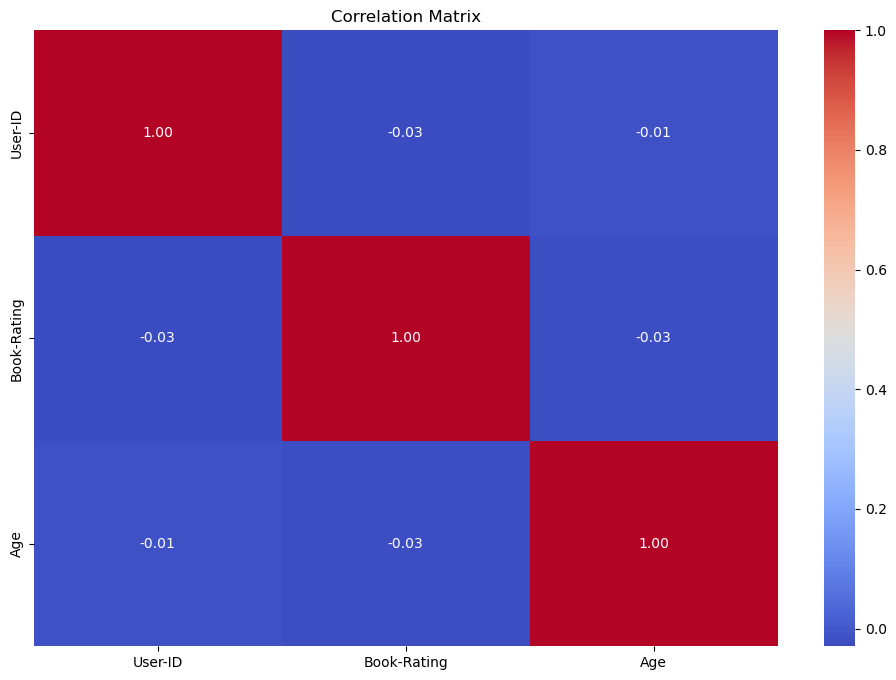

In [5]:
# Select only numeric columns for correlation analysis
numeric_data = complete_df.select_dtypes(include=['number'])

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [6]:
# Set thresholds for filtering
min_ratings_per_book = 10  # Keep books with at least 10 ratings
min_ratings_per_user = 5   # Keep users with at least 5 ratings

# Filter books based on the minimum number of ratings
popular_books = complete_df['Book-Title'].value_counts()
popular_books = popular_books[popular_books >= min_ratings_per_book].index
filtered_df = complete_df[complete_df['Book-Title'].isin(popular_books)]

# Filter users based on the minimum number of ratings
active_users = filtered_df['User-ID'].value_counts()
active_users = active_users[active_users >= min_ratings_per_user].index
filtered_df = filtered_df[filtered_df['User-ID'].isin(active_users)]

# Create the User-Book matrix
user_book_matrix = filtered_df.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating')
user_book_matrix.fillna(0, inplace=True)

# Display the shape of the reduced matrix
print("Shape of the reduced User-Book Matrix:", user_book_matrix.shape)
print("Sample of the reduced User-Book Matrix:")
print(user_book_matrix.head())


Shape of the reduced User-Book Matrix: (9325, 12509)
Sample of the reduced User-Book Matrix:
Book-Title   Q-Space (Star Trek The Next Generation, Book 47)  'Salem's Lot  \
User-ID                                                                       
99                                                        0.0           0.0   
114                                                       0.0           0.0   
165                                                       0.0           0.0   
242                                                       0.0           0.0   
254                                                       0.0           0.0   

Book-Title  ...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR  \
User-ID                                                                    
99                                                        0.0              
114                                                       0.0              
165                                              

In [7]:
# Normalize ratings by subtracting each user's mean rating
user_book_matrix = user_book_matrix.apply(lambda x: x - x.mean(), axis=1)


In [8]:
# Calculate the mean of each user's ratings in the normalized matrix
user_means = user_book_matrix.mean(axis=1)

# Display the mean ratings per user to verify
print("Mean ratings per user after normalization (should be close to 0):")
print(user_means.head())

# Check the overall mean across all users
overall_mean = user_means.mean()
print("\nOverall mean of user ratings after normalization:", overall_mean)


Mean ratings per user after normalization (should be close to 0):
User-ID
99    -1.420063e-19
114   -2.272101e-18
165   -2.307602e-19
242   -3.550158e-19
254   -5.680252e-19
dtype: float64

Overall mean of user ratings after normalization: -3.0814511060884854e-19


In [9]:
# Display a sample of available book titles in the dataset
sample_books = user_book_matrix.columns[:10]  # Adjust the number as needed
print("Sample book titles available in the dataset:")
print(sample_books.tolist())


Sample book titles available in the dataset:
[' Q-Space (Star Trek The Next Generation, Book 47)', "'Salem's Lot", '...AND THE HORSE HE RODE IN ON : THE PEOPLE V. KENNETH STARR', '01-01-00: The Novel of the Millennium', '1,000 Places to See Before You Die', '10 Lb. Penalty', '100 Malicious Little Mysteries', '1001 Ways to Be Romantic', '101 Dalmatians', '14,000 Things to Be Happy About']


In [11]:
# Transpose the matrix and convert it to sparse format
book_user_matrix = csr_matrix(user_book_matrix.T.values)  # Transpose to match books as rows

# Train the KNN model on the transposed matrix (books as rows)
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(book_user_matrix)


NearestNeighbors(algorithm='brute', metric='cosine')

In [15]:
# Testing KNN
def recommend_books(book_title, data, model, n_recommendations=5):
    # Ensure the book title exists in the dataset
    if book_title not in data.columns:
        available_books = data.columns[:10]  # Show first 10 books as examples
        return (f"Book '{book_title}' not found in the dataset. "
                f"Here are some available titles to try: {available_books.tolist()}")

    # Get the index of the book in the transposed matrix
    book_index = data.columns.get_loc(book_title)
    
    # Query the KNN model for similar books
    distances, indices = model.kneighbors(data.T.iloc[book_index].values.reshape(1, -1), n_neighbors=n_recommendations + 1)
    
    # Get the recommended book titles, excluding the input book itself
    recommended_books = [data.columns[i] for i in indices.flatten() if i != book_index]
    
    return recommended_books[:n_recommendations]
# Example usage with an existing title from the dataset
recommended_books = recommend_books("'Salem's Lot", user_book_matrix, model_knn, n_recommendations=5)
print("Books similar to 'Salem's Lot':")
print(recommended_books)

Books similar to 'Salem's Lot':
['Scarlatti Inheritance', 'DARK ANGEL', 'Creed', 'The Matarese Circle', 'Extreme Denial']
